In [37]:
!jupyter nbconvert  '/content/drive/MyDrive/Colab Notebooks/colab_2장.ipynb' --to PDF 

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/colab_2장.ipynb to PDF
[NbConvertApp] Support files will be in colab_2장_files/
[NbConvertApp] Making directory ./colab_2장_files
[NbConvertApp] Writing 54615 bytes to ./notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/jupyter_core/application.py", line 269, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/nbconvert/nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.7/dist-packages/nbconvert/nbconvertapp.py", line 510, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/p

In [36]:
!export PATH=/Library/TeX/texbin:$PATH

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기
dataset = pd.read_csv('car_evaluation.csv')

Saving car_evaluation.csv to car_evaluation.csv


In [3]:
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


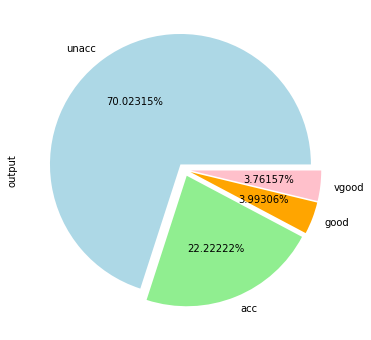

In [4]:
#  output 데이터 시각화
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05,0.05))
# output column의 unique한 values들을 count하여 개수에 따라 pie

In [5]:
# 카테고리 함수들을 type('category')로 설정
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category') 

In [6]:
# 각 카테고리에 맞는 정수값에 매칭
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

# 옆으로 쌓기
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1) 
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [7]:
# tensor 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [8]:
# output은 one-hot encoding
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values # numpy로
outputs = torch.tensor(outputs).flatten() # 텐서로 바꾸고 flatten
#outputs = torch.tensor(outputs).type(torch.DoubleTensor)
print(outputs)

print(categorical_data.shape)
print(outputs.shape)

tensor([0, 0, 1,  ..., 0, 0, 1], dtype=torch.uint8)
torch.Size([1728, 6])
torch.Size([6912])


In [9]:
# 각 feature의 unique value(category) 개수
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
print(categorical_column_sizes)
# embedding 층에 넣을 변수
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[4, 4, 4, 3, 3, 3]
[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [184]:
# train test 비율 나누기
total_records = 1728
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records] 
test_outputs = outputs[total_records-test_records:total_records]

In [185]:
# 각 데이터의 개수
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [186]:
# 아직 embedding이 뭔지 모르겠음..
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols 

        #각 hidden layer 생성 =>총 3개
        for i in layers:
            all_layers.append(nn.Linear(input_size, i)) # linear
            all_layers.append(nn.ReLU(inplace=True)) # relu
            all_layers.append(nn.BatchNorm1d(i)) # batch normalization
            all_layers.append(nn.Dropout(p)) # 드롭아웃
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size)) # 마지막 층 추가 (50,4)
        self.layers = nn.Sequential(*all_layers) # Sequential로 묶어주기

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x) 
        # embedding 층 지난 후 layer층에 forward 진행
        x = self.layers(x)
        return x

In [187]:
# 모델 만들기
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4) # hidden nodes = [200,100,50], dropout 가능성 = 0.4
print(model)
# model = embeddings - embedding_dropout - (Linear-ReLU-BatchNorm1d-Dropout) * 3 - Linear

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [188]:
loss_function = nn.CrossEntropyLoss() # loss function 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer = Adam

In [189]:
# cuda가능하면 cuda로
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [190]:
epochs = 500 # 500번 반복
aggregated_losses = [] # loss 값 모아두기
train_outputs = train_outputs.to(device=device, dtype=torch.int64) # y 값을 GPU로
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs) # y값이랑 비교
    aggregated_losses.append(single_loss) # loss 값 모아두기

    # epoch 25번 돌때마다 loss 값 logging
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad() # backpropagation 전에 미분을 통해 얻은 기울기 초기화 -> 새로운 가중치 편향에 대해서 새로운 기울기를 구할 수 있다
    single_loss.backward() # 미분계산
    optimizer.step() # gradient descent 수행

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.60200131
epoch:  26 loss: 1.41842830
epoch:  51 loss: 1.31766808
epoch:  76 loss: 1.23857212
epoch: 101 loss: 1.08059394
epoch: 126 loss: 0.95956022
epoch: 151 loss: 0.86686587
epoch: 176 loss: 0.75645578
epoch: 201 loss: 0.68695712
epoch: 226 loss: 0.66547132
epoch: 251 loss: 0.64365184
epoch: 276 loss: 0.61051518
epoch: 301 loss: 0.60921496
epoch: 326 loss: 0.59549958
epoch: 351 loss: 0.59456533
epoch: 376 loss: 0.58734173
epoch: 401 loss: 0.58217949
epoch: 426 loss: 0.58708841
epoch: 451 loss: 0.58092284
epoch: 476 loss: 0.58318573
epoch: 500 loss: 0.5747749805


In [191]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
print(type(test_outputs))
# inf 진행
with torch.no_grad():
    y_val = model(categorical_test_data).to(device)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

<class 'torch.Tensor'>
Loss: 0.57462204


In [192]:
print(y_val[:5])

tensor([[ 2.5877,  1.5082, -3.7279, -3.8368],
        [ 2.4250,  1.2852, -2.9522, -2.6486],
        [ 4.0738,  2.8062, -5.2896, -5.5338],
        [ 1.6775,  1.0032, -2.1084, -1.8456],
        [ 1.1425,  0.6467, -0.7507, -0.6026]], device='cuda:0')


In [193]:
y_val = np.argmax(y_val.cpu().numpy(), axis=1) # 가장 큰 label 고르기
print(y_val[:5])

[0 0 0 0 0]


In [194]:
# 평가
import warnings
warnings.filterwarnings('ignore') 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_outputs=test_outputs.cpu().numpy()
print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[258   1]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7478260869565218
